## LoRaWAN Regression to predict Distances

In [113]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

In [130]:
def regression_results(y_test, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_test, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_test, y_pred) 
    mse=metrics.mean_squared_error(y_test, y_pred) 
    median_absolute_error=metrics.median_absolute_error(y_test, y_pred)
    r2=metrics.r2_score(y_test, y_pred)

    print('   explained_variance: ', round(explained_variance,4))    
    print('   r2: ', round(r2,4))
    print('   MAE: ', round(mean_absolute_error,4))
    print('   MSE: ', round(mse,4))
    print('   RMSE: ', round(np.sqrt(mse),4))

### Data Preperation

In [131]:
label = LabelEncoder()
data = pd.read_csv("../data/raw/helium-api-data.csv")
data["datarate"] = label.fit_transform(data["datarate"])
data["valid"] = label.fit_transform(data["valid"])

NUM_WITTNESSES = int(data.index[-1]/data["key"].values[-1])
data

,key,ylat,ylon,xlat,xlon,rssi,snr,freq,datarate,valid,distance
0,0,41.748064,-73.659576,41.734572,-73.692091,-80,11.8,904.099976,1,0,3086.783267
1,0,41.748064,-73.659576,41.765272,-73.633632,-83,11.5,904.099976,1,0,2879.681279
2,0,41.748064,-73.659576,41.728785,-73.705810,-91,11.0,904.099976,1,0,4394.474207
3,1,38.229129,21.762428,38.220871,21.794480,-106,1.2,867.900024,0,0,2946.592328
4,1,38.229129,21.762428,38.194222,21.723213,-109,-0.2,867.900024,0,0,5177.357662
5,1,38.229129,21.762428,38.216455,21.751417,-111,3.2,867.900024,0,0,1706.285590
6,2,37.569662,-77.482763,37.573644,-77.487388,-100,1.0,905.099976,1,0,601.854035
7,2,37.569662,-77.482763,37.567321,-77.479346,-104,0.2,905.099976,1,0,398.097330
8,2,37.569662,-77.482763,37.562791,-77.472571,-107,-5.8,905.099976,1,0,1179.360887
9,3,51.912093,8.411511,51.904937,8.414589,-116,-0.8,867.299988,0,0,823.194152


In [132]:
data = data.drop(data[(data["snr"].values < 3) & (data["snr"].values > -7.5)].index)
data = data.drop(data[data["rssi"].values < -100].index)
data

,key,ylat,ylon,xlat,xlon,rssi,snr,freq,datarate,valid,distance
0,0,41.748064,-73.659576,41.734572,-73.692091,-80,11.8,904.099976,1,0,3086.783267
1,0,41.748064,-73.659576,41.765272,-73.633632,-83,11.5,904.099976,1,0,2879.681279
2,0,41.748064,-73.659576,41.728785,-73.705810,-91,11.0,904.099976,1,0,4394.474207
12,4,29.701556,-98.105289,29.703156,-98.152853,-90,3.2,904.299988,1,0,4597.404997
13,4,29.701556,-98.105289,29.699119,-98.110954,-94,8.8,904.299988,1,0,610.570612
25,8,27.995982,-82.443079,28.004386,-82.440370,-90,11.0,905.099976,1,0,971.585453
30,10,34.160698,-118.944679,34.186780,-118.968412,-80,8.0,904.700012,1,0,3630.147105
31,10,34.160698,-118.944679,34.163848,-118.962123,-87,12.0,904.700012,1,0,1642.740112
32,10,34.160698,-118.944679,34.166037,-118.937751,-98,4.0,904.700012,1,0,871.048882
33,11,37.443960,116.404290,37.436763,116.384207,-97,15.2,487.299988,1,0,1945.230571


In [133]:
y = data["distance"]
X = data.drop(["distance", "ylat", "ylon", "valid"], axis=1)
X

,key,xlat,xlon,rssi,snr,freq,datarate
0,0,41.734572,-73.692091,-80,11.8,904.099976,1
1,0,41.765272,-73.633632,-83,11.5,904.099976,1
2,0,41.728785,-73.705810,-91,11.0,904.099976,1
12,4,29.703156,-98.152853,-90,3.2,904.299988,1
13,4,29.699119,-98.110954,-94,8.8,904.299988,1
25,8,28.004386,-82.440370,-90,11.0,905.099976,1
30,10,34.186780,-118.968412,-80,8.0,904.700012,1
31,10,34.163848,-118.962123,-87,12.0,904.700012,1
32,10,34.166037,-118.937751,-98,4.0,904.700012,1
33,11,37.436763,116.384207,-97,15.2,487.299988,1


In [134]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1007486)

### Linear Regression Model

In [97]:
lin = LinearRegression()
lin.fit(X_train, y_train)
yPred = lin.predict(X_test)
mean_squared_error(yPred, y_test)**.5

2034.209190028035

### Random Forest Regression

In [98]:
random_forest_regression = RandomForestRegressor(n_estimators=100, max_depth=20)
random_forest_regression.fit(X_train, y_train)
random_forest_regression_yPred = random_forest_regression.predict(X_test)

regression_results(y_test, random_forest_regression_yPred)

743.6595815857986

### Randomized Search

In [144]:
rf  = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("estimator", RandomForestRegressor(warm_start=True, oob_score=True))
    ]
)

rgrid = {
    "estimator__n_estimators": np.arange(50,500,10),
    "estimator__criterion": ["squared_error", "absolute_error", "poisson"],
    "estimator__min_samples_split":np.arange(1, 50),
    "estimator__min_samples_leaf":np.arange(1, 50),
    "estimator__max_features": ["sqrt", "log2"],
    "estimator__max_depth": np.arange(2, 20)
}


opt_rf = RandomizedSearchCV(rf, rgrid, cv = 5, scoring="neg_root_mean_squared_error", random_state=1007486)
opt_rf.fit(X_train, y_train)
yrf_pred = opt_rf.predict(X_test)
regression_results(y_test, yrf_pred)
print(opt_rf.best_params_)

   explained_variance:  0.0
   r2:  -0.1514
   MAE:  722.0216
   MSE:  600234.9118
   RMSE:  774.7483
{'estimator__n_estimators': 110, 'estimator__min_samples_split': 41, 'estimator__min_samples_leaf': 14, 'estimator__max_features': 'sqrt', 'estimator__max_depth': 5, 'estimator__criterion': 'absolute_error'}


### Gridsearch

In [119]:
rf  = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("estimator", RandomForestRegressor(warm_start=True, oob_score=True))
    ]
)

rgrid = {
    "estimator__n_estimators": np.arange(50,200,10),
    "estimator__max_depth": np.arange(2, 20)
}


opt_rf = GridSearchCV(rf, rgrid, cv = 5, scoring="neg_root_mean_squared_error")
opt_rf.fit(X_train, y_train)
yrf_pred = opt_rf.predict(X_test)
regression_results(y_test, yrf_pred)
print(opt_rf.best_params_)

   explained_variance:  0.7905
   r2:  -0.2318
   MAE:  730.0524
   MSE:  642171.7465
   RMSE:  801.3562
{'estimator__max_depth': 11, 'estimator__n_estimators': 80}


### GradientBoostingRegressor

In [127]:

pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("estimator", GradientBoostingRegressor())
    ]
)

grid = {
    "estimator__n_estimators": np.arange(10,500,10),
    "estimator__learning_rate": np.linspace(1e-3, 0.5,50),
    "estimator__max_depth": np.arange(1,15), 
    "estimator__min_samples_split": np.linspace(1e-7, 0.99,100),
    "estimator__max_features": ["sqrt", "log2"],
    "estimator__loss": ["squared_error", "absolute_error", "huber", "quantile"]
}

gbt_grid = RandomizedSearchCV(pipeline, grid, cv=5,scoring="neg_root_mean_squared_error", random_state=1007486)

gbt_grid.fit(X_train, y_train)
y_pred = gbt_grid.predict(X_test)
regression_results(y_test, y_pred)
print(gbt_grid.best_params_)

   explained_variance:  0.9194
   r2:  -0.9538
   MAE:  988.1907
   MSE:  1018526.7438
   RMSE:  1009.2209
{'estimator__n_estimators': 450, 'estimator__min_samples_split': 0.39000006060606063, 'estimator__max_features': 'sqrt', 'estimator__max_depth': 13, 'estimator__loss': 'absolute_error', 'estimator__learning_rate': 0.39816326530612245}


### Neural Network

In [141]:
pipe_MLPRegressor = Pipeline(
    [
        ('scaler',  StandardScaler()),
        ('MLPRegressor', MLPRegressor(random_state = 42, max_iter=1000))
    ]
)

grid_params_MLPRegressor = [{
    'MLPRegressor__solver': ['lbfgs'],
    'MLPRegressor__activation' : ['relu','logistic','tanh'],
    'MLPRegressor__hidden_layer_sizes':[(2,), (4,),(2,2),(4,4),(4,2),(10,10),(2,
2,2)],}]


CV_mlpregressor = GridSearchCV(estimator = pipe_MLPRegressor, param_grid = grid_params_MLPRegressor, cv = 5, return_train_score=True, verbose=0)

CV_mlpregressor.fit(X_train, y_train)
y_pred = gbt_grid.predict(X_test)
regression_results(y_test, y_pred)
print(CV_mlpregressor.best_params_)

f:\Python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
f:\Python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


   explained_variance:  0.9194
   r2:  -0.9538
   MAE:  988.1907
   MSE:  1018526.7438
   RMSE:  1009.2209
{'MLPRegressor__activation': 'tanh', 'MLPRegressor__hidden_layer_sizes': (2, 2), 'MLPRegressor__solver': 'lbfgs'}


### PCA

In [123]:
rf  = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("decomposer", PCA()),
        ("estimator", RandomForestRegressor(warm_start=True, oob_score=True))
    ]
)

rgrid = {
    "estimator__n_estimators": np.arange(50,500,10),
    "estimator__criterion": ["squared_error", "absolute_error", "poisson"],
    "estimator__min_samples_split":np.arange(1, 50),
    "estimator__min_samples_leaf":np.arange(1, 50),
    "estimator__max_features": ["sqrt", "log2"],
    "estimator__max_depth": np.arange(2, 20), 
    "decomposer__n_components": np.arange(1, 6)
}


opt_rf = RandomizedSearchCV(rf, rgrid, cv = 5, scoring="neg_root_mean_squared_error", random_state=1007486)
opt_rf.fit(X_train, y_train)
yrf_pred = opt_rf.predict(X_test)
regression_results(y_test, yrf_pred)
print(opt_rf.best_params_)

f:\Python\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "f:\Python\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "f:\Python\lib\site-packages\sklearn\pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "f:\Python\lib\site-packages\sklearn\ensemble\_forest.py", line 476, in fit
    trees = Parallel(
  File "f:\Python\lib\site-packages\joblib\parallel.py", line 1085, in __call__
    if self.dispatch_

   explained_variance:  0.0
   r2:  -0.0575
   MAE:  722.0216
   MSE:  551268.5876
   RMSE:  742.4746
{'estimator__n_estimators': 260, 'estimator__min_samples_split': 17, 'estimator__min_samples_leaf': 30, 'estimator__max_features': 'log2', 'estimator__max_depth': 3, 'estimator__criterion': 'absolute_error', 'decomposer__n_components': 3}


In [126]:
pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("decomposer", PCA()),
        ("estimator", GradientBoostingRegressor())
    ]
)

grid = {
    "estimator__n_estimators": np.arange(10,500,10),
    "estimator__learning_rate": np.linspace(1e-3, 0.5,50),
    "estimator__max_depth": np.arange(1,15), 
    "estimator__min_samples_split": np.linspace(1e-7, 0.99,100),
    "estimator__max_features": ["sqrt", "log2"],
    "estimator__loss": ["squared_error", "absolute_error", "huber", "quantile"],
    "decomposer__n_components": np.arange(1, 7)
}

gbt_grid = RandomizedSearchCV(pipeline, grid, cv=5,scoring="neg_root_mean_squared_error", random_state=1007486)

gbt_grid.fit(X_train, y_train)
y_pred = gbt_grid.predict(X_test)
regression_results(y_test, y_pred)
print(gbt_grid.best_params_)

   explained_variance:  0.0213
   r2:  -0.3765
   MAE:  714.2855
   MSE:  717615.2919
   RMSE:  847.1218
{'estimator__n_estimators': 120, 'estimator__min_samples_split': 0.24000007575757576, 'estimator__max_features': 'sqrt', 'estimator__max_depth': 7, 'estimator__loss': 'huber', 'estimator__learning_rate': 0.001, 'decomposer__n_components': 3}


### Visualization

f:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
f:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


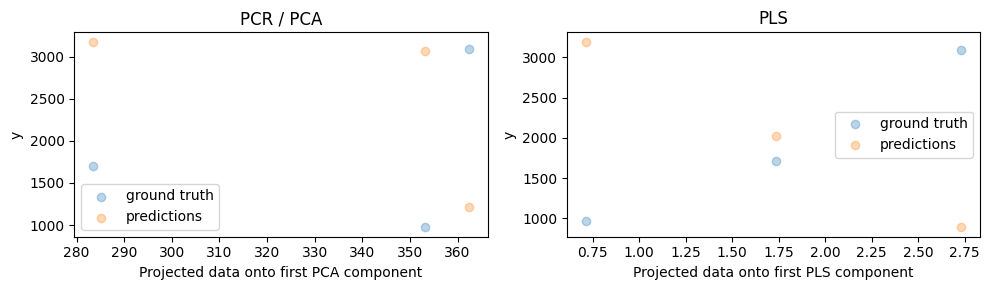

In [61]:

pcr = make_pipeline(StandardScaler(), PCA(n_components=1), LinearRegression())
pcr.fit(X_train, y_train)
pca = pcr.named_steps["pca"]  # retrieve the PCA step of the pipeline

pls = PLSRegression(n_components=1)
pls.fit(X_train, y_train)

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].scatter(pca.transform(X_test), y_test, alpha=0.3, label="ground truth")
axes[0].scatter(
    pca.transform(X_test), pcr.predict(X_test), alpha=0.3, label="predictions"
)
axes[0].set(
    xlabel="Projected data onto first PCA component", ylabel="y", title="PCR / PCA"
)
axes[0].legend()
axes[1].scatter(pls.transform(X_test), y_test, alpha=0.3, label="ground truth")
axes[1].scatter(
    pls.transform(X_test), pls.predict(X_test), alpha=0.3, label="predictions"
)
axes[1].set(xlabel="Projected data onto first PLS component", ylabel="y", title="PLS")
axes[1].legend()
plt.tight_layout()
plt.show()

### Trilateration Test

https://www.alanzucconi.com/2017/03/13/positioning-and-trilateration/

In [ ]:
def mse(x, locations, distances):
    mse = 0.0
    for location, distance in zip(locations, distances):
        distance_calculated = hs.haversine(tuple(x), tuple(location), Unit.METERS)
        mse += math.pow(distance_calculated - distance, 2.0)
    return mse / len(distances)

In [ ]:

min_dist_row = df.loc[:2].sort_values("distance [m]").iloc[0]
initial_location = min_dist_row["lat"], min_dist_row["lng"]

points = [ p for p in list(zip(df["lat"], df["lng"], df["distance [m]"]))]

locations = [(p[0], p[1]) for p in points]
# distances = [p[2] + random.random()*40-20 for p in points[:3]] # experiment with noise
distances = [p[2] for p in points[:3]]

result = minimize(
    mse,                         # The error function
    initial_location,            # The initial guess (e.g. location with minimum distance to point)
    args=(locations, distances), # Additional parameters for mse
    method='L-BFGS-B',           # The optimisation algorithm
    options={
        'ftol':1e-5,         # Tolerance
        'maxiter': 1e+7      # Maximum iterations
    })
location = result.x
location

array([47.58403 , 12.172852])